# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Ivan Castillo
* Adad Flores
* Nadir Rodriguez
* Carlos Perez

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [1]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

In [2]:
 import sys
 print(sys.executable)

/usr/bin/python3


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing the necessary libraries

In [4]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
!pip install tqdm

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [7]:
# Opening JSON file
file_name="/content/complaints.json"
f = file = open(file_name, "r")

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [8]:
df.shape

(78313, 22)

## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
df.tail()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided
78312,complaint-public-v2,complaint,2001189,0.0,None,None,2001189,Payment to acct not credited,2016-07-06T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-07-07T12:00:00-05:00,None,None,Yes,Roughly 10+ years ago I closed out my accounts...,None,Consent provided


In [11]:
df.shape

(78313, 22)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [13]:
# lets check the missing value in descedning order
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)

,0
_source.company_public_response,0.999949
_source.tags,0.860815
_source.sub_issue,0.591179
_source.sub_product,0.134984
_source.zip_code,0.086282
_source.state,0.025424
_source.consumer_consent_provided,0.012871
_source.company,0.000000
_source.complaint_what_happened,0.000000
_source.timely,0.000000


In [14]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [15]:
#Assign new column names
def rename_col(col):
    if col.startswith('_source'):
        col = col[len('_source.'):]
    elif col.startswith('_'):
        col = col[1:]
    return col

In [16]:
df.rename(lambda x: rename_col(x), axis=1, inplace=True)

In [17]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [18]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)


In [19]:
df['complaint_what_happened'][1]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [20]:
#Remove all rows where complaints column is nan
df['complaint_what_happened'].isnull().sum()

57241

In [21]:
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [23]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [24]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()  # Make the text lowercase
  text=re.sub(r'\[.*?\]',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'\n', '', text) # Remove line breaks
  text=re.sub(r'\b\w*\d\w*\b',' ',text) #Remove words with numbers
  text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces

  return text


In [25]:
#df['complaint_what_happened'][101]
#text="I Purchase is an airline ticket on XX/XX/XXXX and it was XXXX dollar but the I [realize] it was the wrong airport so I called right away to cancel the ticket and since it was before 24 hours so I could cancel it and get a refund which is what supposed to post in my account in 5 days and on XX/XX/XXXX I got the money back so I purchase another airline ticket with the same money that I got back but it was XXXX dollar and the money was taking out of my available balance on XX/XX/XXXX but it was saying pending on the statement but it was out of my available balance already on XX/XX/XXXX the XXXX dollar Was taking again out of my account but showing in my account as it was only one charge .. and I am not even able to see the first airline ticket or the refund on my statement because they said it was dropped charge like it was never happened but it did happened..thats not the first time this happened it did happened before but I usually get the money back after the weekend on Monday but this time no it did got back .. I tried calling them and they explaining but they only say one thing.. I dont see it on the statement.. so why I cant see my purchase for the first airline ticket that it was refunded.. this is my money and I am supposed to see all the charges I made and the refund on my account.. I am missing XXXX dollar from my account which is got Disappeared from my bank account and I need to get this money back I dont know what to do"
rows=df.shape[0]
df= df.reset_index(drop=True)

for i in range(rows):
  df['complaint_what_happened'][i]=clean_text(df['complaint_what_happened'][i])


In [ ]:
df['complaint_what_happened']

0       good morning my name is xxxx xxxx and i apprec...
1       i upgraded my xxxx xxxx card in xx xx and was ...
2       chase card was reported on xx xx however fraud...
3       on xx xx while trying to book a xxxx xxxx tick...
4       my grand son give me check for i deposit it in...
                              ...                        
4026    jpmcb auto finance has been on my credit repor...
4027    on xx xx xxxx a vendor double charged my chase...
4028    i filed an application for a mortgage refinanc...
4029    re claim xxxx i do not feel that chase bank pr...
4030    xx xx xxxx dear cfpb i hope this finds you wel...
Name: complaint_what_happened, Length: 4031, dtype: object

In [ ]:
df.shape

(4031, 22)

In [26]:
# Write your function to Lemmatize the texts
import spacy
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and remove stop words
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])

    return lemmatized_text

In [27]:
lemmatize_text(clean_text(df['complaint_what_happened'][101]))

'complaint chase bank deny open checking account refuse explanation chase credit card issue credit card chase bank timeline note check account denial xx xx xxxx meet xxxx xxxx private client banker xxxx xxxx xxxx location open check account check xxxx xxxx xxxx personal checking account chase check recently close chase credit card give pre print check deposit slip chase total checking account xxxx xxxx mention account close review tell reason idea assume boiler plate language assume not close electronically sign document receive copy xx xx xxxx xxxx account alert screen shot new application inquiry xx xx xxxx email chase debit atm xx xx xxxx email chase mobile app request sign mobile app electronic copy disclosure sign open account note long account long access document xx xx xxxx ask xxxx copy document receive printout deposit account agreement privacy notice xx xx xxxx xxxx account alert new account open xx xx xxxx email chase account tool xx xx xxxx receive activate atm card xxxx ex

In [29]:
# Apply data cleaning to the complaints_what_happened column
from tqdm import tqdm
# Use progress_apply from tqdm on the Series
tqdm.pandas()
df_clean = pd.DataFrame()
df_clean['complaints'] = df['complaint_what_happened'].progress_apply(lambda x: clean_text(x))

100%|██████████| 21072/21072 [00:05<00:00, 4120.76it/s]


In [31]:
df_clean.shape

(21072, 1)

In [32]:
tqdm.pandas()
df_clean['lemmatized'] = df_clean['complaints'].progress_apply(lambda x:lemmatize_text(x))

100%|██████████| 21072/21072 [18:00<00:00, 19.51it/s]


In [34]:
df_clean.shape

(21072, 2)

In [35]:
df_clean.head(50)

,complaints,lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in xx xx and was ...,I upgrade my xxxx xxxx card in xx xx and be te...
2,chase card was reported on xx xx however fraud...,chase card be report on xx xx however fraudule...
3,on xx xx while trying to book a xxxx xxxx tick...,on xx xx while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
5,can you please remove inquiry,can you please remove inquiry
6,with out notice j p morgan chase restricted my...,with out notice j p morgan chase restrict my a...
7,during the summer months i experience a declin...,during the summer month I experience a decline...
8,on xxxx xx xx i made a payment to an online re...,on xxxx xx xx I make a payment to an online re...
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...


In [36]:
df_clean.shape

(21072, 2)

In [37]:
#Write your function to extract the POS tags

def extract_pos_tags(text):
    doc = nlp(text)
    pos_tags = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(pos_tags)

df_clean['complaint_POS_removed'] =  df_clean.lemmatized.apply(lambda x: extract_pos_tags(x))
df_clean.head()


,complaints,lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was ...,I upgrade my xxxx xxxx card in xx xx and be te...,xxxx card agent anniversary date agent informa...
2,chase card was reported on xx xx however fraud...,chase card be report on xx xx however fraudule...,chase card report application identity consent...
3,on xx xx while trying to book a xxxx xxxx tick...,on xx xx while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...


In [39]:
extract_pos_tags(df_clean['lemmatized'][0])

'morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account advance help'

In [62]:
def remove_x_variations(text):
    return re.sub(r'\b(x{2,4})\b', '', text, flags=re.IGNORECASE).strip()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [117]:
#Removing NA and XXXX variations of sensible words
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('').astype(str)
df_clean['complaint_POS_cleaned'] = df_clean['complaint_POS_removed'].apply(remove_x_variations)


In [101]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags and without variations of XXXX
df_clean

,complaints,lemmatized,complaint_POS_removed,complaint_POS_cleaned
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was ...,I upgrade my xxxx xxxx card in xx xx and be te...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...
2,chase card was reported on xx xx however fraud...,chase card be report on xx xx however fraudule...,chase card report application identity consent...,chase card report application identity consent...
3,on xx xx while trying to book a xxxx xxxx tick...,on xx xx while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...,xxxx xxxx credit card provider claim purchase ...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year bankin...
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

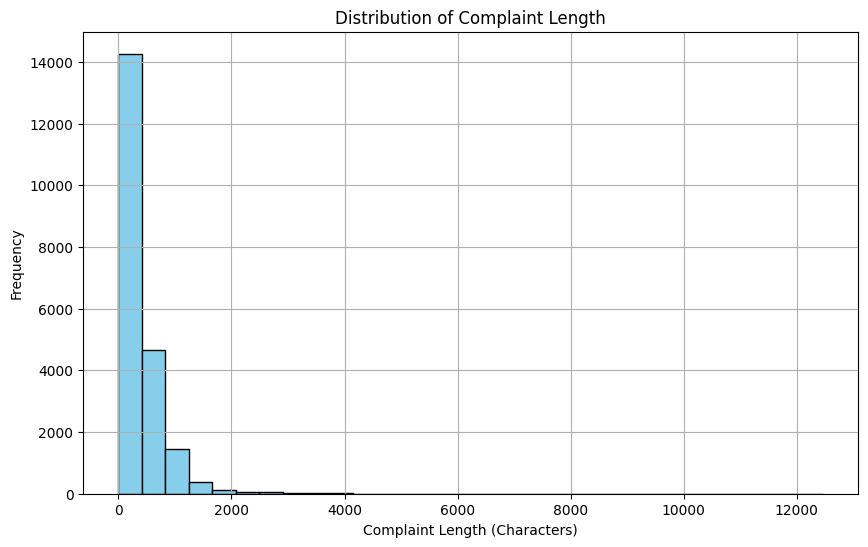

In [102]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10, 6))
plt.hist(df_clean['complaint_POS_cleaned'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Complaint Length (Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Length')
plt.grid(True)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [42]:
!pip install wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


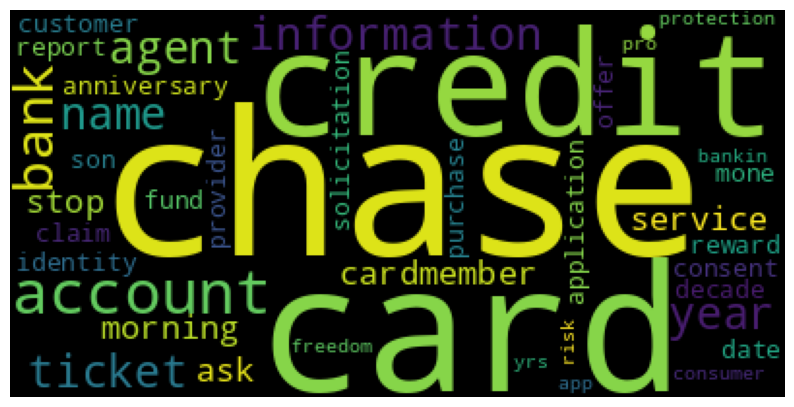

In [103]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_cleaned))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [119]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_cleaned'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_cleaned'],axis = 1)

In [105]:
df_clean ['Complaint_clean']

,Complaint_clean
0,morning name stop bank cardmember service ask ...
1,card agent anniversary date agent information ...
2,chase card report application identity consent...
3,ticket offer ticket reward card information of...
4,son chase account fund chase bank account mone...
...,...
21067,chase card customer decade solicitation credit...
21068,credit card provider claim purchase protection...
21069,risk consumer chase bank app chase year bankin...
21070,credit yrs chase credit card chase freedom pro...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [75]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [76]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)

In [77]:
#Print the top 10 words in the unigram frequency
print("Top 10 Unigrams:")
for word, freq in top_30_unigrams[:10]:
    print(f"{word}: {freq}")

Top 10 Unigrams:
chase: 52096
account: 46677
credit: 33608
card: 30195
payment: 21350
bank: 21185
time: 16262
charge: 14216
day: 13261
check: 12140


In [78]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)

In [79]:
#Print the top 10 words in the bigram frequency
print("Top 10 Bigrams:")
for word, freq in top_30_bigrams[:10]:
    print(f"{word}: {freq}")

Top 10 Bigrams:
credit card: 12908
credit report: 3941
customer service: 3059
account chase: 3038
chase credit: 2905
chase account: 2623
account account: 2445
bank account: 2427
check account: 2330
chase bank: 2089


In [80]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [81]:
#Print the top 10 words in the trigram frequency
print("Top 10 Trigrams:")
for word, freq in top_30_trigrams[:10]:
    print(f"{word}: {freq}")

Top 10 Trigrams:
chase credit card: 1963
credit card account: 1111
credit card company: 998
credit card chase: 748
credit card credit: 554
inquiry credit report: 527
account credit card: 439
card credit card: 427
charge credit card: 416
chase customer service: 399


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Parameters
max_df = 0.95
min_df = 2

# Matrix TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

# Vocabulary Words
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Dimensions TF-IDF: {tfidf_matrix.shape}")

Dimensions TF-IDF: (21072, 6382)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [121]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

print(f"Dimensiones de la DTM: {dtm.shape}")  # (Docs, tokens)

non_zero_entries = list(zip(dtm.nonzero()[0], dtm.nonzero()[1], dtm.data))
print(f"Tuples Examples (complaint_id, token_id, tf-idf): {non_zero_entries[:10]}")


Dimensiones de la DTM: (21072, 6382)
Tuples Examples (complaint_id, token_id, tf-idf): [(0, 3677, 0.22924277928164694), (0, 5490, 0.2778041823096123), (0, 472, 0.19700279947066396), (0, 802, 0.31960077117455615), (0, 5155, 0.13273656892773558), (0, 330, 0.2818855176764765), (0, 1494, 0.545056392288515), (0, 6127, 0.2503189370083033), (0, 5448, 0.15520413998236776), (0, 3398, 0.16274998168010182)]


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [122]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
El modelado de tópicos manual utilizando NMF (Non-Negative Matrix Factorization) permite descubrir temas latentes en un conjunto de documentos. El proceso requiere ajustar iterativamente el número de tópicos (n_components) mediante un enfoque de prueba y error para encontrar la mejor representación de los datos. Este paso es crucial, ya que determina la calidad y la interpretabilidad de los tópicos generados.

In [ ]:
# Cargar y entrenar el modelo con 5 topicos
num_topics = 5 #write the value you want to test out

# Semilla aleatoria = 40 
nmf_model = NMF(n_components=num_topics, random_state=40, max_iter=300)

# Entrenamiento
nmf_model.fit(tfidf_matrix)

W = nmf_model.transform(tfidf_matrix)  # MDocument Matrix
H = nmf_model.components_  # Term Matrix

print(f"W (documento-tópico): {W.shape}")
print(f"H (término-tópico): {H.shape}")

W (documento-tópico): (21072, 5)
H (término-tópico): (5, 6382)


Obtención de las 15 palabras más representativas para cada tópico generado por el modelo NMF. Estas palabras ayudan a interpretar los temas latentes y a etiquetarlos con nombres significativos. 

In [124]:
#Print the Top15 words for each of the topics
def display_topics(H, feature_names, top_words=15):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
        print("-" * 80)

display_topics(H, tfidf_feature_names)

Topic 0:
account, check, bank, money, fund, chase, deposit, branch, day, checking, number, business, transfer, transaction, customer
--------------------------------------------------------------------------------
Topic 1:
card, credit, chase, balance, account, limit, score, year, point, month, purchase, offer, time, application, reason
--------------------------------------------------------------------------------
Topic 2:
payment, loan, mortgage, chase, home, month, modification, time, year, rate, property, balance, statement, date, day
--------------------------------------------------------------------------------
Topic 3:
report, inquiry, credit, company, information, reporting, debt, account, identity, score, theft, letter, date, file, creditor
--------------------------------------------------------------------------------
Topic 4:
charge, dispute, transaction, chase, fee, merchant, claim, fraud, purchase, service, refund, email, time, day, company
-----------------------------

Visualizar los datos limpios

In [125]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in xx xx and was ...,I upgrade my xxxx xxxx card in xx xx and be te...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...
2,chase card was reported on xx xx however fraud...,chase card be report on xx xx however fraudule...,chase card report application identity consent...,chase card report application identity consent...
3,on xx xx while trying to book a xxxx xxxx tick...,on xx xx while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday xx xx xxxx i called chas my xxxx ...,on wednesday xx xx xxxx I call chas my xxxx xx...,xxxx xxxx credit card provider claim purchase ...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year bankin...
21070,i have had flawless credit for yrs i ve had ch...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


Una vez evaluado el mapeo de los tópicos y confirmado que las asignaciones son correctas, procede a etiquetar cada tópico con nombres relevantes que representen de manera clara su contenido. Los nombres sugeridos para los tópicos identificados son:

- Servicios de cuentas bancarias (Bank Account Services): Incluye temas relacionados con cuentas, saldos, depósitos, transacciones y problemas asociados a servicios bancarios generales.
- Tarjetas de crédito o prepagadas (Credit Card or Prepaid Card): Representa tópicos relacionados con el uso, cargos, disputas y problemas de tarjetas de crédito o prepagadas.
- Reporte de robos o disputas (Theft/Dispute Reporting): Agrupa quejas relacionadas con fraudes, transacciones no autorizadas, y reportes de disputas por transacciones incorrectas.
- Hipotecas/Préstamos (Mortgage/Loan): Incluye temas relacionados con hipotecas, tasas de interés, pagos de préstamos y refinanciamiento.
Otros (Others): Agrupa temas diversos que no encajan claramente en los anteriores.

In [ ]:
# Asignar el mejor tópico a cada queja en forma de valores enteros (0, 1, 2, 3, 4)

# Crear un diccionario que asocia los números de los tópicos con sus nombres significativos
topic_names = {
    0: 'Bank Account Services',        # Servicios relacionados con cuentas bancarias
    1: 'Credit Card or Prepaid Card',  # Problemas relacionados con tarjetas de crédito o prepagadas
    2: 'Mortgage/Loan',                # Temas sobre hipotecas o préstamos
    3: 'Theft/Dispute Reporting',      # Reportes de robos o disputas de transacciones
    4: 'Others'                        # Categoría para temas diversos no clasificados
}

# Asignar a cada documento el número del tópico más relevante basado en la matriz documento-tópico W
df_clean['Best_Topic'] = W.argmax(axis=1)

# Mapear los valores numéricos de los tópicos a sus nombres utilizando el diccionario creado
df_clean['Topic_Name'] = df_clean['Best_Topic'].map(topic_names)

                                     Complaint_clean  Best_Topic  \
0  morning name stop bank cardmember service ask ...           0   
1  card agent anniversary date agent information ...           1   
2  chase card report application identity consent...           3   
3  ticket offer ticket reward card information of...           3   
4  son chase account fund chase bank account mone...           0   

                    Topic_Name  
0        Bank Account Services  
1  Credit Card or Prepaid Card  
2      Theft/Dispute Reporting  
3      Theft/Dispute Reporting  
4        Bank Account Services  


In [1]:
# Quejas por tópico
for topic in df_clean['Best_Topic'].unique():
    print(f"Topic {topic}:")
    print(df_clean[df_clean['Best_Topic'] == topic]['Complaint_clean'].head(5))
    print("-" * 80)

NameError: name 'df_clean' is not defined

## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [132]:
from sklearn.model_selection import train_test_split

#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

X = df_clean['Complaint_clean']
y = df_clean['Best_Topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training: {X_train.shape}, Test: {X_test.shape}")


Training: (16857,), Test: (4215,)


In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Dimensions of TF-IDF (Training): {X_train_tfidf.shape}")

Dimensiones de TF-IDF (Entrenamiento): (16857, 5000)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [135]:
#Model 1: Logistic Regresion

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logistic_model = LogisticRegression(random_state=42, max_iter=300)
logistic_model.fit(X_train_tfidf, y_train)

y_pred_logistic = logistic_model.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.9620403321470937
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1037
           1       0.97      0.95      0.96       847
           2       0.96      0.99      0.97       989
           3       0.97      0.95      0.96       470
           4       0.94      0.95      0.94       872

    accuracy                           0.96      4215
   macro avg       0.96      0.96      0.96      4215
weighted avg       0.96      0.96      0.96      4215



In [136]:
#Model 2: Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_tfidf, y_train)

y_pred_forest = random_forest_model.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

Random Forest Accuracy: 0.8842230130486358
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1037
           1       0.87      0.85      0.86       847
           2       0.90      0.94      0.92       989
           3       0.93      0.84      0.88       470
           4       0.86      0.84      0.85       872

    accuracy                           0.88      4215
   macro avg       0.89      0.88      0.88      4215
weighted avg       0.88      0.88      0.88      4215



In [137]:
#Model 3: Decision Trees
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_tfidf, y_train)

y_pred_tree = decision_tree_model.predict(X_test_tfidf)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Decision Tree Accuracy: 0.834638196915777
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1037
           1       0.85      0.85      0.85       847
           2       0.87      0.88      0.88       989
           3       0.88      0.82      0.85       470
           4       0.77      0.78      0.77       872

    accuracy                           0.83      4215
   macro avg       0.84      0.83      0.84      4215
weighted avg       0.83      0.83      0.83      4215



**Clasification of New Complaints**

In [151]:
# Random Forest
# New Complaints
new_complaints = ["My credit card was charged without my authorization",
                  "I need help with my mortgage payment",
                  "My Account was Hacked",
                  "I lost my card",
                  "Help me my son purchased an article very expensive",
                  "I did a transfer but it was duplicated"]

# Transform with TF-IDF
new_complaints_tfidf = vectorizer.transform(new_complaints)

# Clasify with best model
predicted_topics = random_forest_model.predict(new_complaints_tfidf)

# Mapping
predicted_topic_names = [df_clean['Topic_Name'].unique()[topic] for topic in predicted_topics]

for complaint, topic in zip(new_complaints, predicted_topic_names):
    print(f"Complaint: {complaint}")
    print(f"Predicted Topic: {topic}")
    print("-" * 50)

Complaint: My credit card was charged without my authorization
Predicted Topic: Credit Card or Prepaid Card
--------------------------------------------------
Complaint: I need help with my mortgage payment
Predicted Topic: Theft/Dispute Reporting
--------------------------------------------------
Complaint: My Account was Hacked
Predicted Topic: Bank Account Services
--------------------------------------------------
Complaint: I lost my card
Predicted Topic: Credit Card or Prepaid Card
--------------------------------------------------
Complaint: Help me my son purchased an article very expensive
Predicted Topic: Bank Account Services
--------------------------------------------------
Complaint: I did a transfer but it was duplicated
Predicted Topic: Bank Account Services
--------------------------------------------------
Complaint: Help me
Predicted Topic: Bank Account Services
--------------------------------------------------


In [ ]:
# Regresion
new_complaints = [
    "My credit card was charged without my authorization",
    "I need help with my mortgage payment",
    "My Account was Hacked",
    "I lost my card",
    "Help me my son purchased an article very expensive",
    "I did a transfer but it was duplicated"
]

new_complaints_tfidf = vectorizer.transform(new_complaints)

predicted_topics = logistic_model.predict(new_complaints_tfidf)

predicted_topic_names = [df_clean['Topic_Name'].unique()[topic] for topic in predicted_topics]

for complaint, topic in zip(new_complaints, predicted_topic_names):
    print(f"Complaint: {complaint}")
    print(f"Predicted Topic (Logistic Regression): {topic}")
    print("-" * 50)
